# Checking the synchrony between the probe signal and tags recorded with Intan

### synthesized analog signal is recorded by the probe. This generated signal is in sync with two analog and digital tags which were also recorded by Intan. Does Intan induce any delay between the signal and tags?

### Importing Modules 

In [1]:
%reset -f

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import os.path
import os
import pickle
from scipy.ndimage.interpolation import shift
import scipy.stats as stats

from intanRead import IntanRaw_read_data

from tkinter import Tk
from tkinter.filedialog import askopenfilename

## Getting the data file 

In [4]:
defaultDataDir = "C:\\Users\Student\Desktop\RHD2000interface_compiled_v1_5_2"

if not os.path.isdir(defaultDataDir):
    defaultDataDir = "C:\\"
    
root = Tk()
root.withdraw()

dataFileAdd =  askopenfilename(initialdir = defaultDataDir,title = "Select file",\
                            filetypes = (("Intan raw files","*.rhd"),("all files","*.*")))

dataFileName = os.path.basename(dataFileAdd)[:-4]
dataFileBaseFolder = os.path.dirname(dataFileAdd)

## Reading the data file

In [5]:
readResult = IntanRaw_read_data.IntanRaw_read_data(dataFileAdd)


Reading Intan Technologies RHD2000 Data File, Version 1.5

Found 64 amplifier channels.
Found 3 auxiliary input channels.
Found 1 supply voltage channel.
Found 1 board ADC channel.
Found 2 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 8.832 seconds of data.  Amplifiers were sampled at 30.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 1.2 seconds


### Info about this Sync Test data (probeTagSync_181124_141048)

In [6]:
probeSig = deepcopy(readResult['amplifier_data'][0]) #Signal from the first channel on the probe
analogTag = deepcopy(readResult['board_adc_data'][0]) #.astype('int') #port 8 on the intan
digitalTag = deepcopy(readResult['board_dig_in_data'][0]) #.astype('int') #ADC 0 on the intan


Fs = readResult['frequency_parameters']['board_dig_in_sample_rate']

### Recorded Signals and Tags

#### Analog Tags

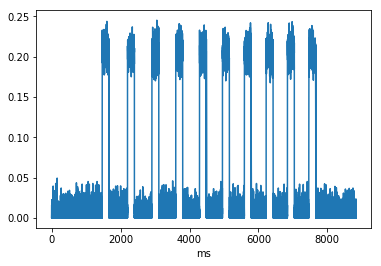

In [7]:
plt.plot(np.arange(0,len(digitalTag))*1e3/Fs,analogTag)
plt.xlabel('ms');

#### digital Tags

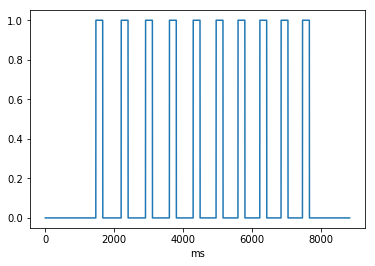

In [8]:
plt.plot(np.arange(0,len(digitalTag))*1e3/Fs,digitalTag)
plt.xlabel('ms');

#### recorded signal on the probe

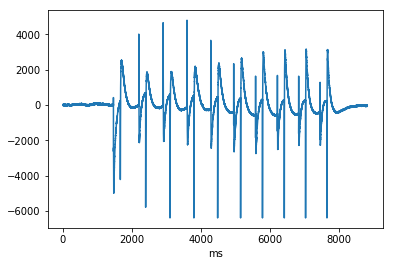

In [9]:
plt.plot(np.arange(0,len(digitalTag))*1e3/Fs,probeSig)
plt.xlabel('ms');

### Detecting the up-transition of the digital signal

In [23]:
upTransitionDigital = np.where ((digitalTag[:-1] == 0)  & (np.diff(digitalTag)>0))[0] 

## Analog Tags triggered by the Digital Tags

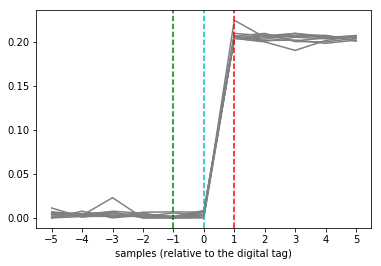

In [30]:
transWindowToLook = 5 # in samples

for tagSample in upTransitionDigital:
    
    plt.plot(np.arange(-transWindowToLook,transWindowToLook+1),\
            analogTag[int(tagSample-transWindowToLook):\
                       int(tagSample+transWindowToLook+1)],'gray')
    
plt.xticks(np.arange(-transWindowToLook,transWindowToLook+1))
plt.axvline(0,color='c',linestyle='--')
plt.axvline(-1,color='g',linestyle='--')
plt.axvline(+1,color='r',linestyle='--')

plt.xlabel('samples (relative to the digital tag)');

## Probe signal triggered by the Digital Tags

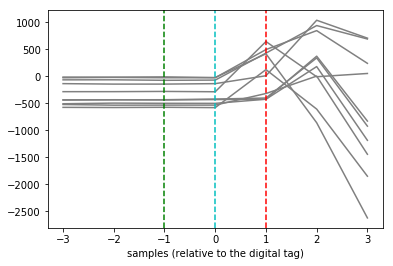

In [32]:
transWindowToLook = 3 # in samples

for tagSample in upTransitionDigital:
    
    plt.plot(np.arange(-transWindowToLook,transWindowToLook+1),\
            probeSig[int(tagSample-transWindowToLook):\
                       int(tagSample+transWindowToLook+1)],'gray')
    
plt.xticks(np.arange(-transWindowToLook,transWindowToLook+1))
plt.axvline(0,color='c',linestyle='--')
plt.axvline(-1,color='g',linestyle='--')
plt.axvline(+1,color='r',linestyle='--')

plt.xlabel('samples (relative to the digital tag)');

## Conclusion

The digital and analog tags are sampled completely in sync with the probe although they are connected to the usb board (and not to the amp board)

### Matlab code that generated the test data used for this analysis

clear all

probeTagSyncTestSession = daq.createSession('ni');
probeTagSyncTestSession.addAnalogOutputChannel('Dev1',0:1,'Voltage');
probeTagSyncTestSession.addDigitalChannel('Dev1','port0/line0','OutputOnly');

recStartStopSession = daq.createSession('ni');
recStartStopSession.addDigitalChannel('Dev1','port1/line0:7','OutputOnly');
recStartTrigger = [0,1,0,0,0,0,0,0];
recStopTrigger = [0,0,0,0,0,0,0,0];

Fs = 100e3; % DAQ sampling frequency (Hz)
probeTagSyncTestSession.Rate = Fs;
probeTagSyncTestSession.outputSingleScan([0 0 0]);
% probeTagSyncTestSession.outputSingleScan([1 1 1]);

stimDur = 2e-1; % in sec
stim = [[ones(stimDur*Fs,1)]',0];
testNo = 10;

recStartStopSession.outputSingleScan(recStartTrigger);

for loop=1:testNo
    
    pause(0.2);

    probeTagSyncTestSession.queueOutputData([0.2*stim',0.2*stim',stim']);
    probeTagSyncTestSession.prepare;

    probeTagSyncTestSession.startBackground();
    
    probeTagSyncTestSession.wait();

end

recStartStopSession.outputSingleScan(recStopTrigger);

probeTagSyncTestSession.release();
probeTagSyncTestSession.removeChannel(1:numel(probeTagSyncTestSession.Channels));


